# Import Libraries and setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#suppressing output of the cell
%%capture  
#installing necessary dependencies
!pip -q install geopandas
!pip -q install geojson
!pip -q install --upgrade folium
!pip -q install geemap
!pip -q install rasterio
!pip -q install geopandas geojson geemap rasterio earthpy
!pip -q install rioxarray
!pip -q install matplotlib numpy

In [ ]:
# importing libraries

import rasterio as rio
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import json
import requests
import glob
from pathlib import Path

import geojson
#import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import ee
import geemap
import geemap.eefolium as emap
import folium
import earthpy.spatial as es
import earthpy.plot as ep

from rasterio.plot import show_hist

import matplotlib.image as mpimg
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import pandas as pd
from scipy import stats
from functools import reduce
import gc 
from IPython.display import display

from  IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from rasterio.plot import show
from sklearn import cluster
import matplotlib.colors as mc
import cv2
from PIL import Image
import matplotlib.gridspec as grid
import tensorflow as tf

# Save before_ndvi, latitude and longitude of all 'before' TIF images

In [ ]:
def ProcessAllImages(cluster_folder): #cluster_folder is actually link to all images TIF folder

  # list of names all images in the given path
  ids = next(os.walk(cluster_folder))[2] 
  print("No. of images in folder = ", len(ids))

  cluster_data = Path(cluster_folder)
  #the png images are stored in the paths list
  cluster_data = glob.glob(os.path.join(cluster_data,'*.tif'))

  df = pd.DataFrame(columns=['img', 'before_ndvi', 'lat', 'long'])

  #loop through all files in the cluster
  for i in range(len(cluster_data)):

    bf_tif = cluster_data[i]

    #loop through all files
    if os.path.isfile(bf_tif):
      raster = rio.open(bf_tif)
      bottom = raster.bounds[1]
      right = raster.bounds[2]
      df = df.append({'img':cluster_data[i], 'before_ndvi':raster.read(17), 'lat':right,'long':bottom},ignore_index = True)
      
    #end of if (that the tif images exist)
    else:
      print(bf_tif+" not found!")

  #end of loop through all images
  #print(df)
  return df

In [ ]:
df = ProcessAllImages('drive/My Drive/kenya_aoi_old/kenya_before/') #Location where all TIF images are stored
df.to_csv('drive/My Drive/LULC_spectral_indices/lat_long_list_all.csv', sep=',', index=False) #CSV where I will save the latitude and longitude

No. of images in folder =  259


# Load Kenya LULC 2019 map

In [ ]:
img = rio.open('drive/My Drive/LULC_spectral_indices/LandCoverClasses.tif')
img.bounds

BoundingBox(left=33.992063492063444, bottom=-3.072420634920558, right=41.90575396825389, top=5.431547619047668)

In [ ]:
print(img.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 7977, 'height': 8572, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0009920634920634888, 0.0, 33.992063492063444,
       0.0, -0.0009920634920634888, 5.431547619047668)}


# Color coding of pixels with landcover type

In [ ]:
df.head(5)

,img,before_ndvi,lat,long
0,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.32280254, 0.2820258, 0.373996, 0.27328113,...",35.823197,2.131523
1,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.120995335, 0.124523506, 0.11989796, 0.1189...",36.357694,1.148227
2,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.19189219, 0.16877024, 0.15916057, 0.217007...",35.782683,2.182277
3,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.13162743, 0.11579785, 0.09753733, 0.112359...",35.810530,2.138440
4,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.2285907, 0.18232045, 0.21859267, 0.202995,...",35.774059,2.188386


In [ ]:
#@title
import csv
#points = []
colorCoding = { '0':'unknown',
                '20':'shrubland',
                '30':'herbaceous_vegetation',
                '40':'cropland',
                '50':'built-up',
                '60':'bare_sparse_vegetation',
                '70':'snow_ice',
                '80':'permanent_inland_water',
                '90':'herbaceous_wetland',
                '100':'moss_lichen',
                '111':'ENF_closed',
                '112':'EBF_closed',
                '113':'DNF_closed',
                '114':'DBF_closed',
                '115':'mixed _closed',
                '116':'unknown_closed',
                '121':'ENF_open',
                '122':'EBF_open',
                '123':'DNF_open',
                '124':'DBF_open',
                '125':'mixed _open',
                '126':'unknown_open',
                '200':'sea'}
#with open("drive/My Drive/LULC_spectral_indices/lat_long_list_all.csv") as inf:
    #reader = csv.reader(inf)
    #isHeading = False
    #for row in reader:
        #if isHeading:
           # print(row)
           # x = float(row[1]) #lat
           # y = float(row[2]) #long
           # print(x, y)
           # points.append((x,y))  
       # isHeading = True 

# Get pixel value & land cover type 

In [ ]:
from osgeo import gdal
import sys

csv_loc = 'drive/My Drive/LULC_spectral_indices/lat_long_list_all.csv'
lulc_map_loc = 'drive/My Drive/LULC_spectral_indices/LandCoverClasses.tif'

# open the raster file
ds = gdal.Open(lulc_map_loc)

if ds is None:
    print('Could not open the raster file')
    sys.exit(1)
else:
    print('The raster file was opened satisfactorily')

# get georeference info
transform = ds.GetGeoTransform() 
xOrigin = transform[0]
yOrigin = transform[3] 
pixelWidth = transform[1]
pixelHeight = transform[5] 

band = ds.GetRasterBand(1) # 1-based index

data = band.ReadAsArray()
df_2 = pd.DataFrame(columns=['img', 'before_ndvi', 'lat', 'long', 'pixel_value', 'Landcover'])

# loop through the coordinates

for index, row in df.iterrows():
    x = row['lat']
    y = row['long']
        
    xOffset = int((x - xOrigin) / pixelWidth)
    yOffset = int((y - yOrigin) / pixelHeight)

  # get individual pixel values
    value = data[yOffset][xOffset]
    Landcover = colorCoding[str(value)]

    df_2 = df_2.append({'img':row['img'], 'before_ndvi': row['before_ndvi'], 'lat':row['lat'],'long':row['long'], 'pixel_value':value, 'Landcover':Landcover },ignore_index = True)
   
df_2.to_csv('drive/My Drive/LULC_spectral_indices/lat_long_list_all_landcover.csv', sep=',', index=False)


# loop through the coordinates
#with open(csv_loc, 'w', newline='') as outf:
#    writer = csv.writer(outf)
#    row_new = ['lat', 'long', 'pixel_value', 'label'] 
 #   writer.writerow(row_new)
#    for point in points:
#        x = point[0]
#        y = point[1]
#
#        xOffset = int((x - xOrigin) / pixelWidth)
#        yOffset = int((y - yOrigin) / pixelHeight)
        #print(xOffset)
        #print(yOffset)
        # get individual pixel values
 #       value = data[yOffset][xOffset]
#        label = colorCoding[str(value)]
        #print(value, label)
        #row_new = [x, y, value, label]
        #writer.writerow(row_new)

#        df_2 = df_2.append({'img':cluster_data[i], 'lat':right,'long':bottom, 'pixel_value':value, 'label':label },ignore_index = True)
#
#df_2.to_csv('drive/My Drive/LULC_spectral_indices/lat_long_list_all_landcover.csv', sep=',', index=False)

The raster file was opened satisfactorily


In [ ]:
df_2.head(5)

,img,before_ndvi,lat,long,pixel_value,Landcover
0,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.32280254, 0.2820258, 0.373996, 0.27328113,...",35.823197,2.131523,20,shrubland
1,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.120995335, 0.124523506, 0.11989796, 0.1189...",36.357694,1.148227,20,shrubland
2,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.19189219, 0.16877024, 0.15916057, 0.217007...",35.782683,2.182277,30,herbaceous_vegetation
3,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.13162743, 0.11579785, 0.09753733, 0.112359...",35.810530,2.138440,30,herbaceous_vegetation
4,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.2285907, 0.18232045, 0.21859267, 0.202995,...",35.774059,2.188386,30,herbaceous_vegetation


# Start NDVI comparison

In [ ]:
df_3 = pd.DataFrame(columns=['img', 'before_ndvi', 'after_ndvi', 'ndvi_diff_max', 'lat', 'long', 'pixel_value', 'Landcover'])

for index, row in df_2.iterrows():

  #before_path = row['img']
  #index1 = before_path.find("/kenya_aoi_before")
  #before_fname = before_path[index1:]
  #after_fname = 'drive/My Drive/dl_aoi/kenya_after' + before_fname 
  #after_ndvi = 0

  after_fname = row['img'].replace("before", "after")

  #print(before_path)
  #print(before_fname)
  #print(after_fname)
  #break

  if os.path.isfile(after_fname):
    #print('after file got ok')
    raster = rio.open(after_fname)
    after_ndvi = raster.read(17)

    ndvi_diff_max = 0 #default value
    before_ndvi =  row['before_ndvi']
    if (before_ndvi.shape==after_ndvi.shape):
      diff_ndvi = before_ndvi - after_ndvi
      ndvi_diff_max = diff_ndvi.max()

      #if (ndvi_diff_max<0) : #alert this means after attack, ndvi increased!
        #print('alert!')

  df_3 = df_3.append({'img':row['img'], 
                          'before_ndvi': before_ndvi, 
                          'after_ndvi':after_ndvi,
                          'ndvi_diff_max':ndvi_diff_max,
                          'lat':row['lat'],
                          'long':row['long'], 
                          'pixel_value':row['pixel_value'], 
                          'Landcover':row['Landcover'] },ignore_index = True)

In [ ]:
df_3.head(5)

,img,before_ndvi,after_ndvi,ndvi_diff_max,lat,long,pixel_value,Landcover
0,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.32280254, 0.2820258, 0.373996, 0.27328113,...","[[0.3321687, 0.28250906, 0.39190376, 0.2411101...",0.141396,35.823197,2.131523,20,shrubland
1,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.120995335, 0.124523506, 0.11989796, 0.1189...","[[0.28255245, 0.29899856, 0.30512378, 0.305499...",0.077310,36.357694,1.148227,20,shrubland
2,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.19189219, 0.16877024, 0.15916057, 0.217007...","[[0.26253268, 0.23429663, 0.20468432, 0.298985...",0.087258,35.782683,2.182277,30,herbaceous_vegetation
3,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.13162743, 0.11579785, 0.09753733, 0.112359...","[[0.16557162, 0.13339034, 0.11398854, 0.146148...",0.140394,35.810530,2.138440,30,herbaceous_vegetation
4,drive/My Drive/kenya_aoi_old/kenya_before/keny...,"[[0.2285907, 0.18232045, 0.21859267, 0.202995,...","[[0.23490241, 0.20208901, 0.2088015, 0.2328180...",0.094080,35.774059,2.188386,30,herbaceous_vegetation


In [ ]:
df_3.to_csv('drive/My Drive/LULC_spectral_indices/lat_long_list_all_landcover_ndvi_diff.csv', sep=',', index=False)

# Grouping by vegetation type 

In [ ]:
from matplotlib.pyplot import pie, axis, show
by_label = df_3.groupby('Landcover').count()
by_label.head(5)

,img,before_ndvi,after_ndvi,ndvi_diff_max,lat,long,pixel_value
Landcover,,,,,,,
bare_sparse_vegetation,59,59,59,59,59,59,59
built-up,3,3,3,3,3,3,3
cropland,9,9,9,9,9,9,9
herbaceous_vegetation,64,64,64,64,64,64,64
shrubland,111,111,111,111,111,111,111


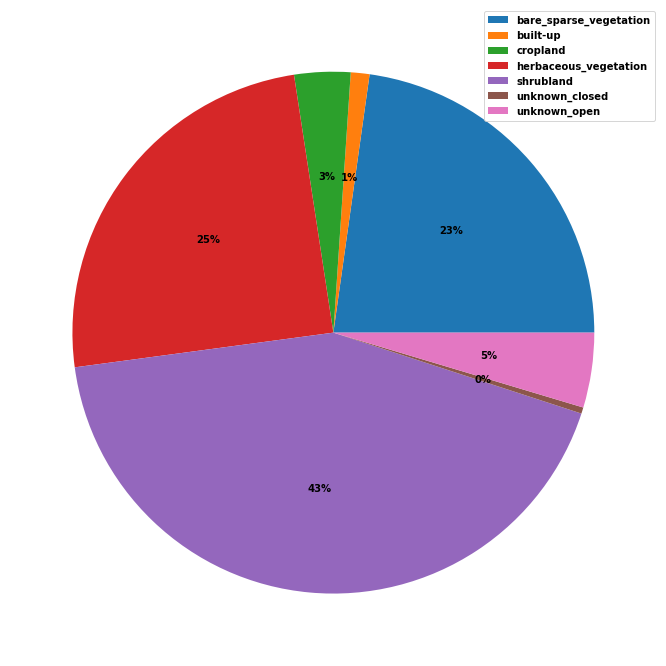

In [ ]:
ax=by_label.groupby(['Landcover']).sum().plot(kind='pie', y='img', labels=None, figsize=(12,12), autopct='%1.0f%%')
ax.yaxis.set_visible(False)

# Avg NDVI per vegetation

In [ ]:
avg_ndvi = df_3.groupby('Landcover')['ndvi_diff_max'].mean()
avg_ndvi

Landcover
bare_sparse_vegetation    0.172555
built-up                  0.323503
cropland                  0.401404
herbaceous_vegetation     0.164143
shrubland                 0.209450
unknown_closed            0.604238
unknown_open              0.371403
Name: ndvi_diff_max, dtype: float64

Text(0.5, 0, 'Max NDVI difference')

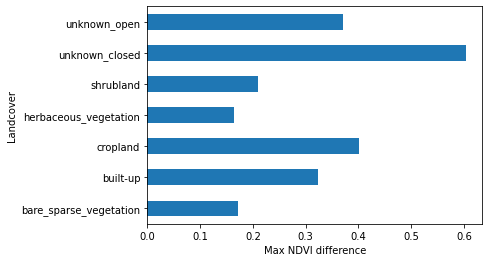

In [ ]:
ax= avg_ndvi.plot(kind="barh", fontsize=10)
ax.set_xlabel("Max NDVI difference")
#ax.set_ylabel("Vegetation category")